# 実機での実行

実機の量子コンピューターで実行する際には、実行時間である QPU time に注意して実行するようにしましょう。事前にシミュレーターや擬似バックエンドでテストし、回路が正しく動くことを確認してから実デバイスで実行します。


## 1. 事前準備
IBMの量子コンピューターを使うためには、まず、[IBM Quantum Platform](https://quantum.cloud.ibm.com/) にサインインするために、IBM Cloud アカウントが必要です。以下の方法で、IBM Cloud アカウントを作成し、[IBM Quantum Platform](https://quantum.cloud.ibm.com/) にサインインしてください。
- 学生(高校生含む)・教育機関に所属する先生は、[「IBM Quantum アカウント設定〜学生・先生バージョン」](https://quantum-tokyo.github.io/introduction/get_started/feature_code.html)に従ってクレジットカードなしで IBM Cloud アカウントの登録を行います。
- 上記以外の方は、[こちら](https://quantum.cloud.ibm.com/registration)から IBM Cloud アカウントを作成してください。その際、有効なメールアドレスとクレジットカード情報が必要となります。

## 2. 量子回路の作成
今回は、ベル状態を例に回路を作成します。

In [1]:
# Qiskitライブラリーを導入
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService

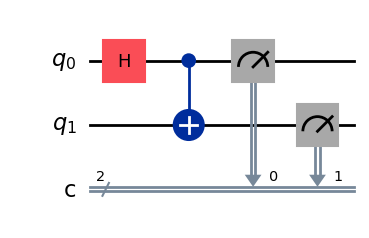

In [2]:
qc = QuantumCircuit(2,2)
qc.h(0) 
qc.cx(0,1) 
qc.measure(0, 0)
qc.measure(1, 1)
qc.draw(output="mpl")

## 3. 量子シミュレーターでの実行
まずはシミュレーターで実験してみます。Qiskit Aerを使います。

{'11': 523, '00': 501}


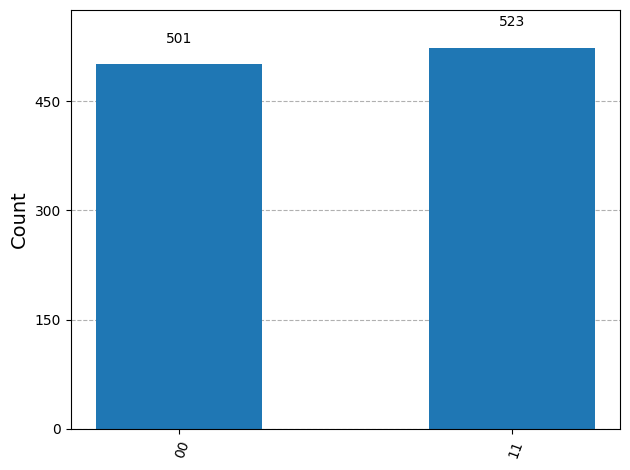

In [3]:
# シミュレーターで実験
backend = AerSimulator()
sampler = Sampler(backend)
job = sampler.run([qc])
result = job.result()

#  測定された回数を表示
counts = result[0].data.c.get_counts()
print(counts)

# ヒストグラムで測定された確率をプロット
plot_histogram( counts )

## 4. フェイクデバイスでの実行
実機の量子コンピューターで実験する前に、実際の量子コンピューターをモデル化した(量子ノイズもデバイスごとにモデル化されています) 擬似バックエンドである Fake device で実行してみます。今回は、[FakeTorino](https://quantum.cloud.ibm.com/docs/ja/api/qiskit-ibm-runtime/fake-provider-fake-torino) デバイスを使います。

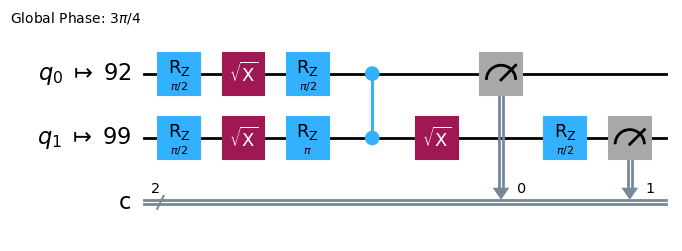

In [4]:
from qiskit_ibm_runtime import fake_provider
backend_fake = fake_provider.FakeTorino()

# 擬似バックエンドでの実行に最適な回路にトランスパイルします
pm = generate_preset_pass_manager(backend=backend_fake, optimization_level=3)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

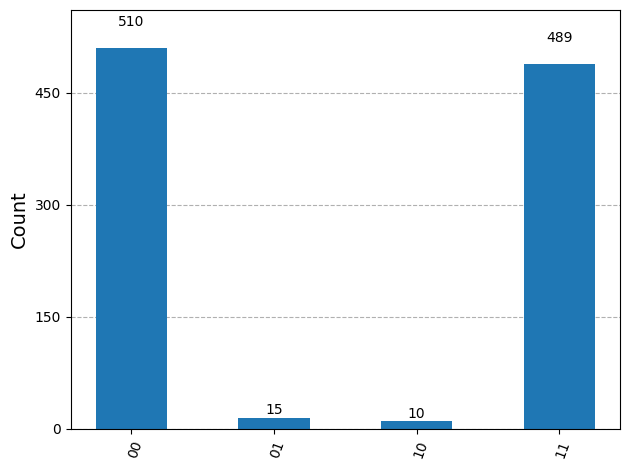

In [5]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend_fake)
job = sampler.run([isa_circuit]) # デフォルトのショット数は1024です

result = job.result()
plot_histogram(result[0].data.c.get_counts())

## 5. 実機で実行する

実量子コンピューターで実験するため次の手順で、API keyとCRNを次のセルのコードに入力してください。 

1) https://quantum.cloud.ibm.com/ にサインインし、左側 「API key」の横にある「Create +」をクリックします。
![image.png](./images/apikey_1.png)

2) API keyの名前（例：my API など）を自由に入力し、「Create」をクリックします。
![image.png](./images/apikey_2.png)

3) 「Download」をクリックして「apikey.json」ファイルを保存します。
![image.png](./images/apikey_3.png)

4) 先ほど保存した「apikey.json」ファイルから、apikeyをコピーして、次のセルの `deleteThisAndPasteYourAPIKeyHere` に上書きしてください。
![image.png](./images/apikey_4.png)

5) CRNをコピーして、次のセルの `deleteThisAndPasteYourCRNHere` に上書きしてください。
![image.png](./images/crn_image.png)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

your_api_key = "deleteThisAndPasteYourAPIKeyHere"
your_crn = "deleteThisAndPasteYourCRNHere"

service = QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=your_api_key, 
    instance=your_crn, 
    set_as_default=True, 
    overwrite=True,
)

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
service.backends()

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]

In [9]:
# 以下でデバイスを指定できます。
backend = service.backend('ibm_brisbane') 

In [10]:
#一番空いているバックエンドを自動的に選択することもできます
backend = service.least_busy(operational=True)
print("最も空いているバックエンドは: ", backend)

最も空いているバックエンドは:  <IBMBackend('ibm_torino')>


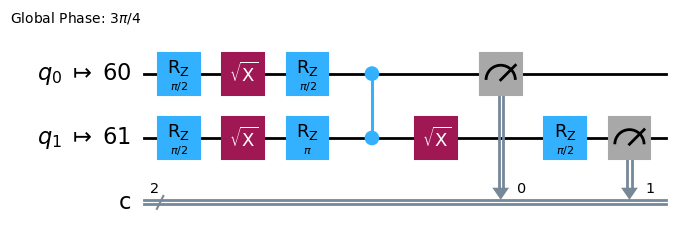

In [11]:
# 実機のバックエンドでの実行に最適な回路にトランスパイルします
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

**注意！！以下のセルを実行すると、実機の量子コンピューターで実行されます。QPU 時間を無駄に消費しないために、回路に問題がないかシミュレーターや擬似デバイスで確認してから実行しましょう。Open userの方の QPU 時間の上限は1ヶ月に10分です。**

In [12]:
# Samplerで実行します
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend)
job = sampler.run([isa_circuit]) # デフォルトのショット数は4096です

print("job id:", job.job_id()) # 実行に時間がかかるのでjob_idを表示します

job id: d3tm08cv6o9s73ct2c1g


以下のコマンドでjobのstatus(実行状況)を確認します。

In [13]:
job = service.job(job.job_id()) 
#job = service.job("d3tm08cv6o9s73ct2c1g") 
job.status() # ジョブの実行状態を確認します

'QUEUED'

In [14]:
# 待ち時間が長い時に後から結果を確認する場合
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()  
job= service.job('d3tm08cv6o9s73ct2c1g') # 例です。上に出力された自分のjob_idを入れて実行してください。
job.status() # ジョブの実行状態を確認します

'QUEUED'

上記のセルを何回か実行して、'DONE' が表示されたら、実機での実行が終わっているので、以下のセルを実行して結果を確認します。

In [13]:
### 'DONE'になってから実行します ###
result = job.result()
print(result[0].data.c.get_counts())

{'00': 2067, '11': 1936, '10': 44, '01': 49}


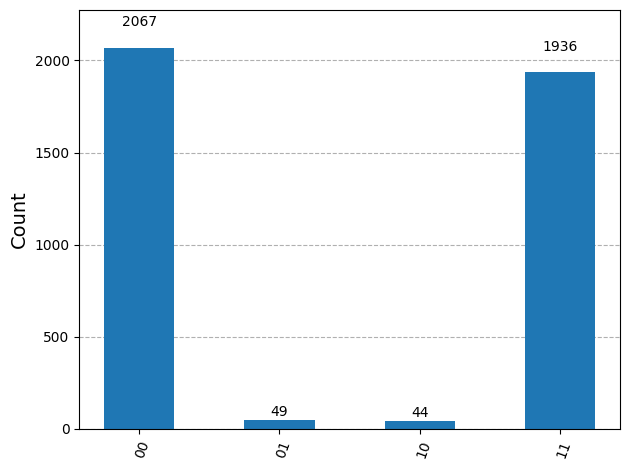

In [14]:
plot_histogram(result[0].data.c.get_counts())

In [15]:
# Qiskitバージョンの確認
import qiskit
qiskit.__version__

'2.1.2'